In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # messages: list[str]
    # The `add_messages` function in the annotation defines how this state key is updated
    # in this case, it appends new messages to the list, rather than replacing it.

    messages: Annotated[list, add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [25]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("google_genai:gemini-2.5-flash-lite")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.5-flash-lite', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x11a4cad50>, default_metadata=(), model_kwargs={})

In [26]:
## Node Functionality
def chatbot(state: State):
    return {"messages":[llm.invoke(state["messages"])]}

In [27]:
graph_builder = StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)

## Adding Edges
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

## compiling the graph
graph = graph_builder.compile()

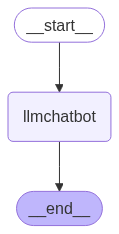

In [28]:
## Visualizing the graph
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [29]:
response = graph.invoke({"messages": "Hello, how are you?"})

In [30]:
response["messages"]

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='b452e7fc-7b4d-4d63-bf75-c3c08ae74888'),
 AIMessage(content="Hello! I'm doing well, thank you for asking. As a large language model, I don't experience feelings in the same way humans do, but I'm functioning optimally and ready to assist you.\n\nHow are you today? What can I help you with?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--a523d536-2ba9-4363-98e9-323e5624a9c6-0', usage_metadata={'input_tokens': 7, 'output_tokens': 57, 'total_tokens': 64, 'input_token_details': {'cache_read': 0}})]

In [10]:
response["messages"][-1].content

"Hello! I am doing well, thank you for asking. I am an AI, so I don't experience feelings in the same way humans do, but I am functioning optimally and ready to assist you.\n\nHow are you today? Is there anything I can help you with?"

In [11]:
for event in graph.stream({"messages": "Give me a 5 different variants of python code to calculate the factorial of a number"}):
    for value in event.values():
        print(value["messages"][-1].content)
# This will print the response from the chatbot as it streams
# Note: The streaming will continue until the end of the response is reached.
# You can stop the streaming by interrupting the kernel or stopping the execution.

Here are 5 different Python code variants to calculate the factorial of a number, showcasing various approaches:

**1. Iterative Approach (using a `for` loop)**

This is a straightforward and common way to calculate factorial.

```python
def factorial_iterative(n):
  """Calculates the factorial of a non-negative integer using a for loop."""
  if n < 0:
    return "Factorial is not defined for negative numbers"
  elif n == 0:
    return 1
  else:
    result = 1
    for i in range(1, n + 1):
      result *= i
    return result

# Example usage:
num = 5
print(f"The factorial of {num} (iterative) is: {factorial_iterative(num)}")
```

**Explanation:**
*   It handles negative numbers and the base case of 0.
*   It initializes `result` to 1.
*   It iterates from 1 up to `n` (inclusive), multiplying `result` by each number.

**2. Iterative Approach (using a `while` loop)**

Similar to the `for` loop, but uses a `while` loop for iteration.

```python
def factorial_while(n):
  """Calculates the 

## Chatbot With Tool

In [12]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)

tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/langgraph',
   'title': 'What is LangGraph?',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. **Nodes**: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling co

In [13]:
## Custom Function

def multiply(a: int, b: int) -> int:
    """Miltiply a and b
    Args:
        a (int): First number
        b (int): Second number
    Returns:
        int: Product of a and b
    """
    return a * b

In [14]:
tools = [tool, multiply]

In [15]:
llm_with_tools = llm.bind_tools(tools)

llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-2.5-flash-lite', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x10d24ef90>, default_metadata=(), model_kwargs={}), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of d

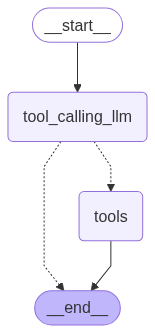

In [16]:
## StateGraph with Tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition
def tool_calling_llm(state: State):
    """Node that calls the LLM with tools"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Grapg definition
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools=tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from the assistant is a tool call, then tools_condition routes the flow to the tools node
    # if not, it routes to the END node
    tools_condition
)

graph_builder.add_edge("tools", END)
graph_builder.add_edge("tool_calling_llm", END)

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
response = graph.invoke({"messages": "What is the recent ai news?"})
response

{'messages': [HumanMessage(content='What is the recent ai news?', additional_kwargs={}, response_metadata={}, id='b0e865ec-69e4-4f51-be13-ec3b2a860d19'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "AI news", "topic": "news", "time_range": "day"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--f00af8f9-88af-4bfb-b199-9579eb47f0a6-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'AI news', 'topic': 'news', 'time_range': 'day'}, 'id': 'd950040b-a24a-49d6-8094-d10eacde8f55', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1327, 'output_tokens': 30, 'total_tokens': 1357, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/sili

In [18]:
response['messages'][-1].content

'{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/silicon-valleys-pro-ai-pacs-influencing-us-midterm-elections/", "title": "Silicon Valley’s Pro-AI PACs Influencing US Midterm Elections - Startup Ecosystem Canada", "score": 0.37986192, "published_date": "Mon, 25 Aug 2025 20:10:01 GMT", "content": "## Silicon Valley’s Pro-AI PACs Influencing US Midterm Elections Silicon Valley heavyweights, including venture-capital firm Andreessen Horowitz and OpenAI President Greg Brockman, are investing over $100 million into a new network of political-action committees (PACs) aimed at advocating for AI-friendly regulations during the upcoming US midterm elections. AI regulationGlobal startup newsPolitical action committeesTech industry lobbyingUS midterm elections techcrunch.com #### Silicon Valley is pouring millions into pro-AI PACs to sway midterms #### Silicon Valley is pouring millions into pro-AI PACs to s

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (d950040b-a24a-49d6-8094-d10eacde8f55)
 Call ID: d950040b-a24a-49d6-8094-d10eacde8f55
  Args:
    query: AI news
    topic: news
    time_range: day
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/silicon-valleys-pro-ai-pacs-influencing-us-midterm-elections/", "title": "Silicon Valley’s Pro-AI PACs Influencing US Midterm Elections - Startup Ecosystem Canada", "score": 0.37986192, "published_date": "Mon, 25 Aug 2025 20:10:01 GMT", "content": "## Silicon Valley’s Pro-AI PACs Influencing US Midterm Elections Silicon Valley heavyweights, including venture-capital firm Andreessen Horowit

In [20]:
response = graph.invoke({"messages": "What is 2 times 3?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (c5c909c4-2c4f-45e9-94f5-d1cdd799248b)
 Call ID: c5c909c4-2c4f-45e9-94f5-d1cdd799248b
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6


In [21]:
response = graph.invoke({"messages": "What is 2 times 3 multiplied by -4?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times 3 multiplied by -4?
================================== Ai Message ==================================
Tool Calls:
  multiply (3f8cb512-0400-4c40-b0c5-f53007db6d6e)
 Call ID: 3f8cb512-0400-4c40-b0c5-f53007db6d6e
  Args:
    a: 2.0
    b: 3.0
  multiply (6ed31cbd-4914-4fe0-996b-9ee88878a66b)
 Call ID: 6ed31cbd-4914-4fe0-996b-9ee88878a66b
  Args:
    a: -12.0
    b: -4.0
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: multiply

48


In [26]:
response = graph.invoke({"messages": "Give me the recenet Tech News and then multiply 2 and 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recenet Tech News and then multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (a8e64ce6-977a-4d89-a124-4aae1e8ccb07)
 Call ID: a8e64ce6-977a-4d89-a124-4aae1e8ccb07
  Args:
    query: Tech News
    topic: news
  multiply (13329619-9d88-416a-b4dd-5096ca753cad)
 Call ID: 13329619-9d88-416a-b4dd-5096ca753cad
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: tavily_search

{"query": "Tech News", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.telecomstechnews.com/news/the-human-firewall-building-a-cyber-aware-workforce/", "title": "The human firewall: Building a cyber-aware workforce - Telecoms Tech News", "score": 0.51310796, "published_date": "Tue, 12 Aug 2025 15:45:07 GMT", "content": "Image 1: Telecoms Tech News

## ReAct Agent Architecture

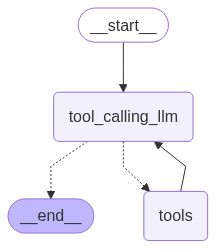

In [22]:
## StateGraph with Tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Node definition
def tool_calling_llm(state: State):
    """Node that calls the LLM with tools"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Grapg definition
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools=tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from the assistant is a tool call, then tools_condition routes the flow to the tools node
    # if not, it routes to the END node
    tools_condition
)

graph_builder.add_edge("tools", "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm", END)

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [31]:
response = graph.invoke({"messages": "Give me the recenet Finance News and then multiply 2 and 3"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recenet Finance News and then multiply 2 and 3
================================== Ai Message ==================================

Here's a look at some recent finance news and the answer to your calculation:

## Recent Finance News (as of late May/early June 2024 - please note news is constantly evolving):

**Global Economic Landscape:**

*   **Inflation Concerns Persist, but Signs of Cooling:** While inflation remains a concern in many economies, there are some indications of it moderating. Central banks are still closely watching price pressures, particularly in services.
*   **Interest Rate Decisions:** Many central banks, like the US Federal Reserve and the European Central Bank, are maintaining current interest rate levels or signaling a cautious approach to any potential rate cuts. The timing and pace of future rate adjustments remain a key focus for markets.
*   **Geopolitical Tensions a

## Adding Memory In Agentic Graph

In [32]:
response = graph.invoke({"messages": "Hi! My name is Dhruv"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! My name is Dhruv
================================== Ai Message ==================================

Hi Dhruv! It's nice to meet you. How can I help you today?


In [33]:
response = graph.invoke({"messages": "Hi! What is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! What is my name?
================================== Ai Message ==================================

I do not have access to your personal information, including your name. I am a large language model, trained by Google.


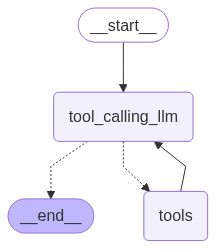

In [37]:
## StateGraph with Tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Node definition
def tool_calling_llm(state: State):
    """Node that calls the LLM with tools"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Grapg definition
graph_builder = StateGraph(State)
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools=tools))

graph_builder.add_edge(START, "tool_calling_llm")
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    # if the latest message from the assistant is a tool call, then tools_condition routes the flow to the tools node
    # if not, it routes to the END node
    tools_condition
)

graph_builder.add_edge("tools", "tool_calling_llm")
graph_builder.add_edge("tool_calling_llm", END)

graph = graph_builder.compile(checkpointer=memory)

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [38]:
config = {"configurable": {"thread_id":"1"}}
response = graph.invoke({"messages": "Hi! My name is Dhruv"}, config=config)
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

Hi! My name is Dhruv
================================== Ai Message ==================================

Hi Dhruv, it's nice to meet you! How can I help you today?


In [39]:
response = graph.invoke({"messages": "Hi! What is my name?"}, config=config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! My name is Dhruv
================================== Ai Message ==================================

Hi Dhruv, it's nice to meet you! How can I help you today?
================================ Human Message =================================

Hi! What is my name?
================================== Ai Message ==================================

Your name is Dhruv.


## Streaming

In [48]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [49]:
def superbot(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

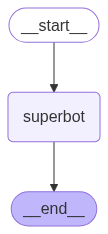

In [50]:
graph = StateGraph(State)
graph.add_node("superbot", superbot)
graph.add_edge(START, "superbot")
graph.add_edge("superbot", END)

graph = graph.compile(checkpointer=memory)

#display(graph)aying the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [54]:
config = {"configurable": {"thread_id":"4"}}
response = graph.invoke({"messages": "Hi! My name is Dhruv and I like Finance"}, config=config)
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi! My name is Dhruv and I like Finance
================================== Ai Message ==================================

Hi Dhruv! It's great to meet you. Finance is a fascinating field with so many different avenues to explore.

What specifically about finance interests you the most? Are you drawn to:

*   **Investing?** (Stocks, bonds, mutual funds, ETFs, etc.)
*   **Corporate Finance?** (How companies manage their money, raise capital, make strategic decisions)
*   **Personal Finance?** (Budgeting, saving, debt management, retirement planning)
*   **Financial Markets?** (How exchanges work, trading, market dynamics)
*   **Financial Technology (FinTech)?** (The intersection of finance and technology)
*   **Accounting?** (The language of business, tracking financial transactions)
*   **Financial Planning/Advisory?** (Helping individuals and families achieve their financial goals)
*   **Something else en

In [55]:
config = {"configurable": {"thread_id":"5"}}
for chunk in graph.stream({"messages": "Hi, My name is Dhruv and I like Finance"}, config=config, stream_mode="updates"):
    for value in chunk.values():
        print(value["messages"][-1].content)

Hi Dhruv! It's great to meet you. Finance is a fascinating and incredibly important field.

What specifically about finance do you find most interesting? Are you drawn to:

*   **Investing?** (Stocks, bonds, real estate, etc.)
*   **Corporate Finance?** (How companies manage their money, raise capital, make financial decisions)
*   **Personal Finance?** (Budgeting, saving, debt management, financial planning for individuals)
*   **Financial Markets?** (How exchanges work, market trends, trading)
*   **Economics?** (The broader study of how economies function)
*   **Something else entirely?**

Knowing what sparks your interest will help me understand how I can best chat with you about finance. I'm here to discuss anything from basic concepts to more complex topics. What's on your mind today?


In [56]:
config = {"configurable": {"thread_id":"5"}}
for chunk in graph.stream({"messages": "What are top job roles in this area?"}, config=config, stream_mode="values"):
    for m in chunk['messages']:
        m.pretty_print()

================================ Human Message =================================

Hi, My name is Dhruv and I like Finance
================================== Ai Message ==================================

Hi Dhruv! It's great to meet you. Finance is a fascinating and incredibly important field.

What specifically about finance do you find most interesting? Are you drawn to:

*   **Investing?** (Stocks, bonds, real estate, etc.)
*   **Corporate Finance?** (How companies manage their money, raise capital, make financial decisions)
*   **Personal Finance?** (Budgeting, saving, debt management, financial planning for individuals)
*   **Financial Markets?** (How exchanges work, market trends, trading)
*   **Economics?** (The broader study of how economies function)
*   **Something else entirely?**

Knowing what sparks your interest will help me understand how I can best chat with you about finance. I'm here to discuss anything from basic concepts to more complex topics. What's on your mind t

In [58]:
config = {"configurable": {"thread_id":"6"}}
async for chunk in graph.astream_events({"messages": "Hi, My name is Dhruv and I like playing badminton"}, config=config, stream_mode="updates"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, My name is Dhruv and I like playing badminton'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '4552d2c6-e7f6-456e-acdf-1caffa8bb2ec', 'metadata': {'thread_id': '6'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is Dhruv and I like playing badminton', additional_kwargs={}, response_metadata={}, id='9bbe0bbc-4703-4c90-b222-a73123e3d445'), AIMessage(content="Hi Dhruv! It's great to meet you! Badminton is a fantastic sport. What do you enjoy most about playing it? Are you a beginner, intermediate, or advanced player? Do you have a favorite player or team you follow? I'd love to hear more about your passion for badminton!", additional_kwargs={}, response_metadata={'safety_ratings': [], 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite'}, id='run--19e6c3c4-1c73-4553-8267-ee18c5a38a60', usage_metadata={'input_tokens': 13, 'output_tokens': 62, 'total_tok

## Human in the Loop

In [59]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.5-flash-lite")
llm

ChatGoogleGenerativeAI(model='models/gemini-2.5-flash-lite', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x11a61ccd0>, default_metadata=(), model_kwargs={})

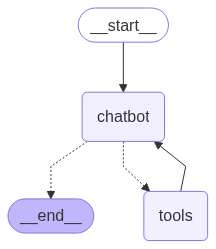

In [62]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool

from langchain_tavily import TavilySearch

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Get human assistance for the query"""
    human_response = interrupt({"query":query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

graph_builder.add_node("chatbot",chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools",tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

#displaying the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [63]:
user_input = "I need some expert advice on investing in stocks. Could you request assistance for me?"
config = {"configurable": {"thread_id":"7"}}

event = graph.stream(
    {"messages": user_input}, 
    config=config, 
    stream_mode="values"
)
for event in event:
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

I need some expert advice on investing in stocks. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (05c302e3-4198-463a-a069-99d0e4a135ef)
 Call ID: 05c302e3-4198-463a-a069-99d0e4a135ef
  Args:
    query: Expert advice on investing in stocks


In [65]:
human_response = (
    "Sure, I recommend diversifying your portfolio across various sectors. "
    "Consider investing in index funds for broad market exposure and consult with a financial advisor for personalized advice."
)

human_command = Command(resume={"data": human_response})

for event in graph.stream(human_command, config=config, stream_mode="values"):
    if "messages" in event:
        event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (05c302e3-4198-463a-a069-99d0e4a135ef)
 Call ID: 05c302e3-4198-463a-a069-99d0e4a135ef
  Args:
    query: Expert advice on investing in stocks
================================= Tool Message =================================
Name: human_assistance

Sure, I recommend diversifying your portfolio across various sectors. Consider investing in index funds for broad market exposure and consult with a financial advisor for personalized advice.
================================== Ai Message ==================================

I recommend diversifying your portfolio across various sectors. Consider investing in index funds for broad market exposure and consult with a financial advisor for personalized advice.
